# Augmented Dataset Try.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  9 20:33:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run if using Google Colab

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary packages
!pip install datasets
!pip install transformers

### Creating Test, Train, and Validation Data

In [3]:
# Load datasets from files
from datasets import load_dataset

# Create Datast object from dataframe
from datasets import Dataset

# Split data into train and test sets
from sklearn.model_selection import train_test_split

# Collate data for training with batches
from transformers import DataCollatorWithPadding

# For linear decay in learning rate
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# Adam optimizer
from tensorflow.keras.optimizers import Adam

# For training
import tensorflow as tf

# To load pretrained model
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Drive path - Change this to your Drive path with the datasets.
path = '/content/drive/MyDrive/Proyectos/NLP ResMex/'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_theme()

In [4]:
# Check GPU availability
import torch

torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [5]:
# Load data obtained from Yelp dataset
data_yelp_df = pd.read_csv(path + 'yelp_translated.csv')

# Drop column with opinions in English
data_yelp_df = data_yelp_df.drop(columns=['Opinion'])

# Rename columns
data_yelp_df = data_yelp_df.rename(columns={'Translation': 'Opinion'})

# Drop attraction column
data_yelp_df = data_yelp_df.drop(columns=['Attraction'])
data_yelp_df.head(3)

,Polarity,Opinion
0,3.0,Cena familiar. Tenía el buffet. Surtido ecléct...
1,4.0,El bollo lo hace el Perro Sonorense. Es como u...
2,4.0,"Sí, este es el único lugar de sushi en la ciud..."


In [6]:
# Drop nan values in Opinion column (they are not useful)
data_yelp_df = data_yelp_df.dropna(subset=['Opinion'])

In [11]:
# Load provided train data
data_df = pd.read_excel(path + 'train_sentiment_analysis.xlsx')

data_df.head(3)

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1.0,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1.0,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1.0,Hotel


In [12]:
# Merge Title and Opinion columns
for index in data_df.index:
    data_df.at[index, 'Opinion'] = str(data_df.at[index, 'Opinion']) \
        + '. ' + str(data_df.at[index, 'Title'])

# Drop Title and Attraction columns
data_df = data_df.drop(columns=['Title', 'Attraction'])

data_df.head(3)

,Opinion,Polarity
0,"Piensen dos veces antes de ir a este hotel, te...",1.0
1,Cuatro de nosotros fuimos recientemente a Eddi...,1.0
2,seguiré corta y simple: limpieza\n- bad. Tengo...,1.0


In [13]:
data_df['Opinion'][0]

'Piensen dos veces antes de ir a este hotel, te molestan por todo, mi hijo de seis años traía un inflable de tamaño pequeño y nos decían que era muy grande ahí lo veían llorando y aún así seguían molestando, traíamos una hielera que parece bolsa nada de grande o con ruedas o de ese estilo y Tmb molestándonos las bebidas carísimas y ni agua te dejan tener en la alberca y no hay ni huéspedes en el hotel esto es en el mayan palace el grand mayan pude ser un poco mejor pero la verdad jamás vuelvo a venir a este lugar, te invitan a una cena show de mil pesos por persona y la cena es hoy dogs, las habitaciones nada fuera de lo normal. Pésimo lugar'

In [ ]:
# Drop nan values in Opinion column (they are not useful)
data_df = data_df.dropna(subset=['Opinion'])

In [ ]:
# Test split from original data
train_df, test_df = train_test_split(data_df, test_size=0.15, random_state=43)

# Size of train and test sets
print(f'Size of train set: {len(train_df)}')
print(f'Size of test set: {len(test_df)}')

# Check proportion of labels
train_prop = train_df['Polarity'].value_counts(normalize=True)
test_prop = test_df['Polarity'].value_counts(normalize=True)

for i in range(1, 6):
    print(f'LABEL {i} - Train:{train_prop[i]:.4f}\t Test:{test_prop[i]:.4f}\t Prop:{train_prop[i]/test_prop[i]:.4f}')

Size of train set: 25680
Size of test set: 4532
LABEL 1 - Train:0.0182	 Test:0.0177	 Prop:1.0302
LABEL 2 - Train:0.0241	 Test:0.0243	 Prop:0.9947
LABEL 3 - Train:0.0693	 Test:0.0752	 Prop:0.9212
LABEL 4 - Train:0.1938	 Test:0.1990	 Prop:0.9736
LABEL 5 - Train:0.6946	 Test:0.6838	 Prop:1.0158


In [ ]:
# Save real Test set
test_df.to_csv(path + save + 'test_data.csv', index=False)

# Merge train and augmented data
data = pd.concat([train_df, data_yelp_df])

# Delete variables
del data_df, train_df, test_df, data_yelp_df

# Number of data points
print(f'Data shape: {data.shape}')

# Clean label column
data.rename(columns={'Polarity': 'label'}, inplace=True)

# To int type
data['label'] = data['label'].astype(int)

Data shape: (71181, 2)


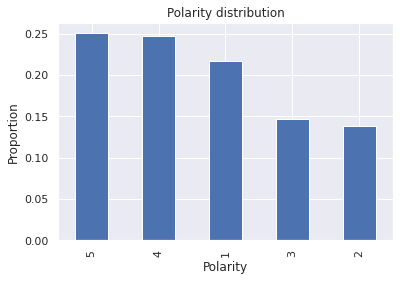

In [ ]:
# Check for balanced classes - histogram
data['label'].value_counts(normalize=True).plot(kind='bar')
plt.title('Polarity distribution')
plt.xlabel('Polarity')
plt.ylabel('Proportion')
plt.show()

In [ ]:
# Rename labels (Keras stars label count at 0)
data['label'] = data['label'].replace({1:0, 2:1, 3:2, 4:3, 5:4})

In [ ]:
# Convert dataframe to Dataset object
dataset = Dataset.from_pandas(data, preserve_index=False, split = 'train')

# Select only 10% of full data - COMMENT THIS LINE IN FULL TRAINING.
# dataset = dataset.train_test_split(train_size=0.2, seed=42)['train']

# Create Test split
dataset = dataset.train_test_split(train_size=0.9, seed=42)

# Create validation split
dataset_aux = dataset['train'].train_test_split(train_size=0.8, seed=42)
dataset_aux['validation'] = dataset_aux.pop('test')
dataset_aux['test'] = dataset['test']

# Rename dataset
dataset = dataset_aux
del dataset_aux

dataset

DatasetDict({
    train: Dataset({
        features: ['Opinion', 'label'],
        num_rows: 51249
    })
    validation: Dataset({
        features: ['Opinion', 'label'],
        num_rows: 12813
    })
    test: Dataset({
        features: ['Opinion', 'label'],
        num_rows: 7119
    })
})

In [ ]:
# Check one element
dataset['train'][5]

{'Opinion': 'El equipo de “Joy Squad” fue muy amable y divertido, definitivamente quiero volver :)\n(Kimberly)\nEl hotel se ve increíble de día y noche\nEstamos emocionados por la encendida del árbol navideño, y esta precioso. Buen Ambiente en Mayan',
 'label': 4}

In [ ]:
# Columns
dataset['train'].features

{'Opinion': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
# Pre-train checkpoint model from 🤗 (MIT License)
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'

# Load model tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_function(example):
    try:
        return tokenizer(example['Opinion'], truncation=True)
    except:
        print(example['Opinion'])

In [ ]:
# Testing tokenizer
example = tokenize_function(dataset['train'][5])

print(dict(example))

{'input_ids': [101, 10117, 13898, 10102, 100, 27318, 23336, 100, 10565, 13653, 22079, 11522, 167, 78000, 26538, 10351, 117, 33045, 85396, 41275, 131, 114, 113, 13311, 94739, 114, 10117, 12752, 10128, 10312, 13565, 31261, 11522, 10102, 10604, 167, 25605, 10602, 14000, 10252, 77953, 40286, 10107, 10190, 10106, 10109, 83259, 11548, 10134, 48058, 37624, 10683, 10132, 117, 167, 10602, 77273, 11513, 119, 40362, 20980, 10109, 25019, 10115, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Visualize tokenization
print(tokenizer.convert_ids_to_tokens(example["input_ids"]))

['[CLS]', 'el', 'equipo', 'de', '[UNK]', 'joy', 'squad', '[UNK]', 'fue', 'muy', 'ama', '##ble', 'y', 'dive', '##rti', '##do', ',', 'definitivamente', 'quiero', 'volver', ':', ')', '(', 'kim', '##berly', ')', 'el', 'hotel', 'se', 've', 'inc', '##rei', '##ble', 'de', 'dia', 'y', 'noche', 'esta', '##mos', 'em', '##ocio', '##nado', '##s', 'por', 'la', 'en', '##cend', '##ida', 'del', 'arbol', 'navi', '##den', '##o', ',', 'y', 'esta', 'precio', '##so', '.', 'buen', 'ambiente', 'en', 'maya', '##n', '[SEP]']


In [ ]:
# Tokenize whole dataset
dataset = dataset.map(tokenize_function, batched=True)

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
# New datast structure
dataset

DatasetDict({
    train: Dataset({
        features: ['Opinion', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 51249
    })
    validation: Dataset({
        features: ['Opinion', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12813
    })
    test: Dataset({
        features: ['Opinion', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7119
    })
})

In [ ]:
# Data collator for batch processing
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
# Batch size and number of epochs
batch_size = 8 # K80 = 6, T4 = 8, P100 = 8, V100 = ?
num_epochs = 6

# Train set
tf_train_dataset = dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

# Validation set
tf_validation_dataset = dataset["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

# Test set
tf_test_dataset = dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

In [ ]:
def eval_model(model, validation_dataset, dataset, path = 'no'):
    """Model evaluation

    Prints MAE, accuracy and confusion matrix for the given model and dataset.
    Args:
        model (tf.keras.Model): Model to evaluate
        validation_dataset (tf.data.Dataset): Dataset to evaluate on
        dataset (Dataset): Dataset to evaluate

    Returns:
        None
    """
    preds = model.predict(validation_dataset)["logits"]
    preds = np.argmax(preds, axis=1)
    true = list(dataset['test']['label'])

    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true, preds)
    print(f'MAE: {mae.result().numpy()}')

    acc = tf.keras.metrics.Accuracy()
    acc.update_state(true, preds)
    print(f'Accuracy: {acc.result().numpy()}')

    cm = confusion_matrix(true, preds)

    df = pd.DataFrame(cm)

    sns.set(font_scale=1.4)
    sns.heatmap(df, annot=True, annot_kws={"size": 16},
                cmap="Greens", fmt='.1f',
                cbar_kws={'label': 'count'}, cbar = False)

    # Colorbar
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    if path != 'no':
        plt.savefig(path + 'matrix.png')
        with open(path + 'test.txt', 'w') as f:
            f.write(f'Accuracy: {acc.result().numpy()}')
            f.write(f'MAE: {mae.result().numpy()}')
    plt.show()

## Training the model.

In [ ]:
# Training steps
num_train_steps = len(tf_train_dataset) * num_epochs

# linear decay of learning rate
lr_scheduler = PolynomialDecay(
    initial_learning_rate=1e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

# Optimizer
opt = Adam(learning_rate=lr_scheduler)

# Loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Compile the model
model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy', 'mean_absolute_error'])

Downloading:   0%|          | 0.00/639M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
save = 'models/model_FULL_total'
filename= path + save + '/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

**a** 

In [ ]:
# Perform training
train = model.fit(tf_train_dataset,
                    validation_data=tf_validation_dataset,
                    epochs=num_epochs, 
                    callbacks=[history_logger])

Epoch 1/6
6406/6406 [==============================] - 3500s 543ms/step - loss: 0.6763 - accuracy: 0.7118 - mean_absolute_error: 2.9627 - val_loss: 0.6219 - val_accuracy: 0.7368 - val_mean_absolute_error: 3.1362
Epoch 2/6
6406/6406 [==============================] - 3468s 541ms/step - loss: 0.5588 - accuracy: 0.7609 - mean_absolute_error: 3.2083 - val_loss: 0.6247 - val_accuracy: 0.7409 - val_mean_absolute_error: 3.4307
Epoch 3/6
6406/6406 [==============================] - 3460s 540ms/step - loss: 0.4700 - accuracy: 0.8038 - mean_absolute_error: 3.4358 - val_loss: 0.6376 - val_accuracy: 0.7393 - val_mean_absolute_error: 3.5634
Epoch 4/6
6406/6406 [==============================] - 3462s 540ms/step - loss: 0.3800 - accuracy: 0.8441 - mean_absolute_error: 3.6548 - val_loss: 0.6983 - val_accuracy: 0.7431 - val_mean_absolute_error: 3.7565
Epoch 5/6
6406/6406 [==============================] - 3455s 539ms/step - loss: 0.3020 - accuracy: 0.8816 - mean_absolute_error: 3.7940 - val_loss: 0.77

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 11 22:46:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    39W / 250W |  15853MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# history options
print(train.history.keys())

dict_keys(['loss', 'accuracy', 'mean_absolute_error', 'val_loss', 'val_accuracy', 'val_mean_absolute_error'])


In [ ]:
train.history['val_accuracy']

[0.7368297576904297,
 0.7408881783485413,
 0.7393272519111633,
 0.7430734634399414,
 0.7367517352104187,
 0.7372199892997742]

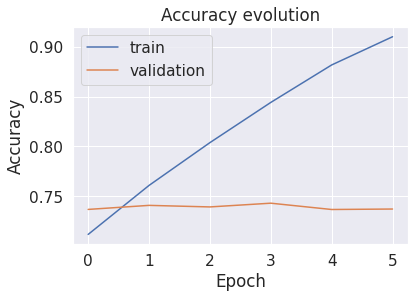

In [ ]:
# accuracy evolution
plt.plot(train.history['accuracy'])
plt.plot(train.history['val_accuracy'])
plt.title('Accuracy evolution')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

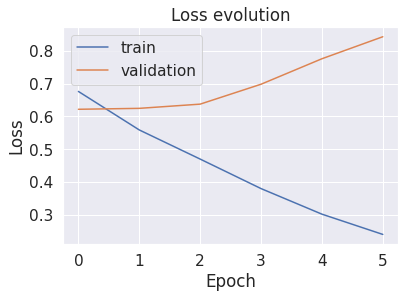

In [ ]:
# loss evolution
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

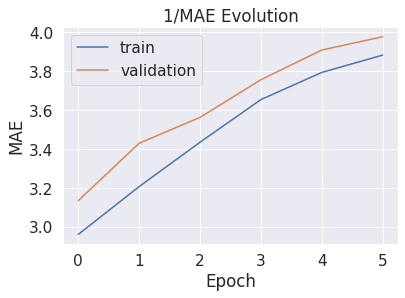

In [ ]:
# MAE evolution
plt.plot(train.history['mean_absolute_error'])
plt.plot(train.history['val_mean_absolute_error'])
plt.title('1/MAE Evolution')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save_pretrained(path + save)

## Evaluating the model. 

### With test set from augmentation dataset.

Some layers from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_FULL_total were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_FULL_total.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions w

MAE: 0.29526618123054504
Accuracy: 0.730299174785614


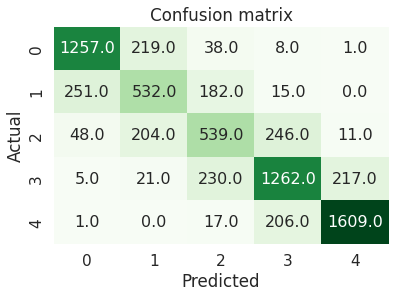

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(path + save)

eval_model(model, tf_test_dataset, dataset)

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


MAE: 0.4648124873638153
Accuracy: 0.6203118562698364


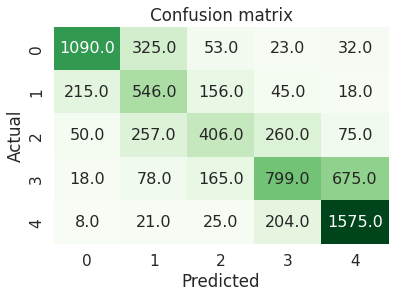

In [ ]:
pre_train = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

eval_model(pre_train, tf_test_dataset, dataset)

### With real test set:

In [ ]:
# Load provided train data
data_df = pd.read_csv(path + 'test_data.csv')

# Rename labels (Keras stars label count at 0)
data_df['label'] = data_df['Polarity'].replace({1:0, 2:1, 3:2, 4:3, 5:4})
data_df = data_df.drop(columns = ['Polarity'])

print(len(data_df))
data_df.head()

4532


,Opinion,label
0,"Como propietarios durante más de una década, v...",4.0
1,"No hay mucho que hacer, solo es parte de la hi...",3.0
2,La cena fue deliciosa. El servicio era increíb...,4.0
3,"La comida es muy rica, un extenso menú donde p...",3.0
4,Hemos tenido el desayuno aquí unas cuantas vec...,4.0


In [ ]:
# Convert dataframe to Dataset object
dataset = Dataset.from_pandas(data_df, preserve_index=False, split = 'train')

# Tokenize whole dataset
dataset = dataset.map(tokenize_function, batched=True).train_test_split(train_size=0.01, seed=42)

# Test set
tf_real_test = dataset['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

  0%|          | 0/5 [00:00<?, ?ba/s]

Some layers from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_FULL_total were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Proyectos/NLP ResMex/models/model_FULL_total.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions w

MAE: 0.2649877369403839
Accuracy: 0.7539559006690979


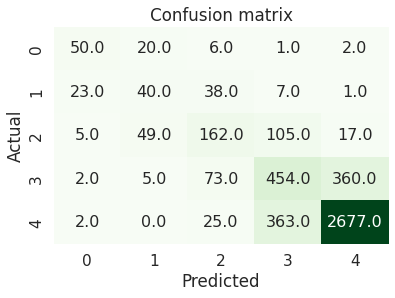

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(path + save)

eval_model(model, tf_real_test, dataset, path = path + save + '/')

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


MAE: 0.3583686351776123
Accuracy: 0.7062625288963318


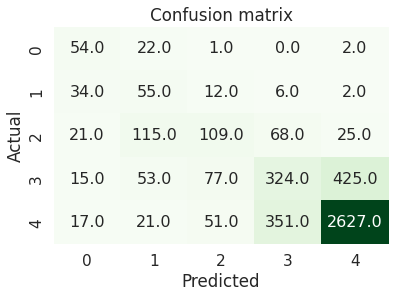

In [ ]:
pre_train = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

eval_model(pre_train, tf_real_test, dataset)